# Natural Language Processing Disaster Tweets Challenge
# By: Bianca Verlangieri

# Brief description
This challenge involves building a natural language processing model to predict which tweets are about real disasters and which tweets are not. The challenge has a data set of 10,000 tweets that were labeled as disaster related or not. The tweets will be cleaned and then converted to matrix form (aka word embedding). We will build a sequential neural network model in the RNN family to predict if each tweet is about a real disaster or not.

In [1]:
# Import libraries
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras import optimizers

In [2]:
# Read in data
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Exploratory Data Analysis
The training and test data sets contain tweets with full text, a location of where the tweet was made, and a keyword tagged. You can see a preview of the training data set in the next code sections. Not all data entries will have a location or a keyword. There are 7613 entries in the training data set. We will convert the text to strings, convert to all lowercase, then remove any special characters to make the data ready for our machine learning model. We will also drop the keyword and location fields for now, and just focus on using the text. In later models we might want to use this information, but since not all entries have them, we will skip it for now. Most importantly, we will drop any stopwords, which are commons words like "the" and "a", since we want to focus on words that will provide more value.

In [3]:
# preview data
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# preview data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Create function to clean text feature
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\d+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    return text

In [6]:
# apply text cleaning
train_data['text'] = train_data['text'].apply(text_cleaning)
test_data['text'] = test_data['text'].apply(text_cleaning)
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [7]:
# remove stopwords
def func_remove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword
train_data['text'] = train_data['text'].apply(func_remove_stopword)
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [8]:
# Drop features we don't plan to use initially
del train_data['keyword']
del test_data['location']

Now that we have clean data, we will apply word embedding, which is taking the text we have and converting it into a matrix format for our machine learning model. The method we will use is called Tokenization, which breaks text up into small tokens and constructs a document word matrix. A collection of document is called Corpus. Each row will represent a document, each column a unique token, and each cell the frequency of the token. We will restrict the number of token to 2000 words. We will also use pad_sequences here, which will ensure each tweet is the same length.

After word embedding, we'll split the training data set into training and validation so we can check if we are overfitting before we run against the test data set. We'll make X the text from tweets, and Y the predicted label (disaster related or not), which comes from the target column.

In [9]:
# Use Tokenizer for word embedding
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(train_data['text'].values)
train_data_matrix = tokenizer.texts_to_sequences(train_data["text"].values)
train_data_matrix = pad_sequences(train_data_matrix,maxlen=20)
test_data_matrix = tokenizer.texts_to_sequences(test_data['text'].values)
test_data_matrix = pad_sequences(test_data_matrix,maxlen=20)

In [10]:
# Split training data set into training and validate, and X and Y
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data_matrix, train_data['target'], test_size=0.15, random_state=1)
X_train = X_train[:, :, None]
X_valid = X_valid[:, :, None]
X_test = test_data_matrix[:, :, None]
Y_train = Y_train[:, None]
Y_valid = Y_valid[:, None]

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape)

(6471, 20, 1) (1142, 20, 1) (3263, 20, 1)
(6471, 1) (1142, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


# Model Architecture
Now that we have our text into matrix form, specifically a Tokenizer object, we can build our natural language processing model. We will start with a recurrent neural network (RNN), which is suited for text and sequential data. Specifically, we'll use a LSTM, which stands for long short-term memory network. It should do well for this sequential data text problem. For the LSTM layer, we'll use the default activation function (different than recurrent activation) of tanh to handle the vanishing gradient problem. We'll start with binary cross entropy for the loss function. For the optimizer, we'll start with adam and potentially change that in our next model if needed. We'll use a batch size of 32 to speed up the training.

In [11]:
# Create LSTM model one
model_one = Sequential()
model_one.add(Embedding(2000,32,input_length = X_train.shape[1]))
model_one.add(LSTM(32))
model_one.add(Dense(1,activation='sigmoid'))
model_one.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model_one.summary())

2023-02-12 01:29:50.152134: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            64000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 72,353
Trainable params: 72,353
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Train the model using the training data set, test against validation data
history_model_one = model_one.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=10)

Epoch 1/10


2023-02-12 01:29:50.560005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


203/203 [==============================] - 8s 24ms/step - loss: 0.5905 - accuracy: 0.6857 - val_loss: 0.4516 - val_accuracy: 0.7986
Epoch 2/10
203/203 [==============================] - 4s 22ms/step - loss: 0.3955 - accuracy: 0.8312 - val_loss: 0.4469 - val_accuracy: 0.7863
Epoch 3/10
203/203 [==============================] - 4s 21ms/step - loss: 0.3502 - accuracy: 0.8535 - val_loss: 0.4593 - val_accuracy: 0.7898
Epoch 4/10
203/203 [==============================] - 5s 23ms/step - loss: 0.3261 - accuracy: 0.8614 - val_loss: 0.4769 - val_accuracy: 0.7776
Epoch 5/10
203/203 [==============================] - 5s 24ms/step - loss: 0.3022 - accuracy: 0.8776 - val_loss: 0.4911 - val_accuracy: 0.7785
Epoch 6/10
203/203 [==============================] - 5s 22ms/step - loss: 0.2798 - accuracy: 0.8898 - val_loss: 0.5247 - val_accuracy: 0.7898
Epoch 7/10
203/203 [==============================] - 4s 21ms/step - loss: 0.2534 - accuracy: 0.9028 - val_loss: 0.5836 - val_accuracy: 0.7776
Epoch 8/10

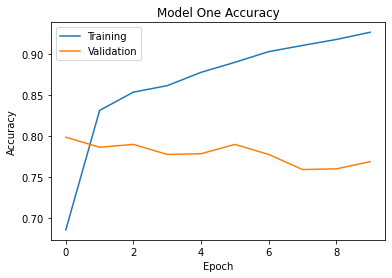

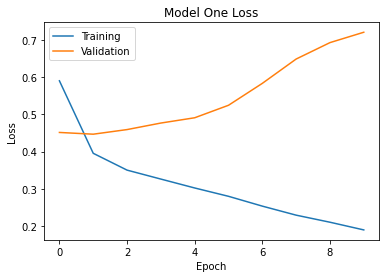

In [13]:
# Plot Accuracy per Epoch for Model One
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Plot Loss per Epoch for Model One
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Results and Analysis
The first model trained very quickly, thanks to our pad sequencing, tokenization, and batch size. The training accuracy and loss were very good after 10 epochs, however, the validation data accuracy and loss started off well but started to get worse at the end of the epochs. This is an indication of overfitting to the training data. To address this, we'll add in some dropout layers. We'll also try out a bidirectional LSTM. In addition, we will only train to 5 epochs, to avoid overtraining.

In [14]:
# Create LSTM model two
model_two = Sequential()
model_two.add(Embedding(2000,32,input_length = X_train.shape[1]))
model_two.add(Bidirectional(LSTM(32)))
model_two.add(Dropout(0.2))
model_two.add(Dense(16,activation='relu'))
model_two.add(Dropout(0.2))
model_two.add(Dense(1,activation='sigmoid'))
model_two.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model_two.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 81,697
Trainable params: 81,697
Non-trainable params: 0
__________________________________________________

In [15]:
# Train the model using the training data set, test against validation data
history_model_two = model_two.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=5)

Epoch 1/5
203/203 [==============================] - 14s 43ms/step - loss: 0.5962 - accuracy: 0.6770 - val_loss: 0.4582 - val_accuracy: 0.7968
Epoch 2/5
203/203 [==============================] - 7s 37ms/step - loss: 0.4025 - accuracy: 0.8323 - val_loss: 0.4454 - val_accuracy: 0.7960
Epoch 3/5
203/203 [==============================] - 7s 37ms/step - loss: 0.3573 - accuracy: 0.8578 - val_loss: 0.4637 - val_accuracy: 0.7837
Epoch 4/5
203/203 [==============================] - 8s 40ms/step - loss: 0.3316 - accuracy: 0.8688 - val_loss: 0.5051 - val_accuracy: 0.7846
Epoch 5/5
203/203 [==============================] - 7s 36ms/step - loss: 0.3060 - accuracy: 0.8776 - val_loss: 0.5329 - val_accuracy: 0.7811


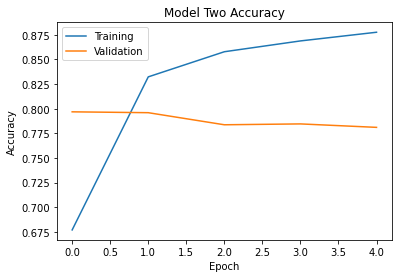

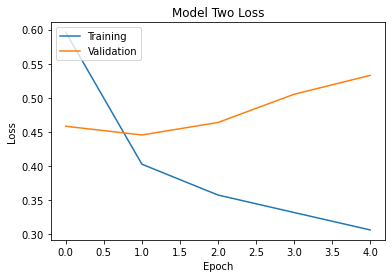

In [16]:
# Plot Accuracy per Epoch for Model Two
plt.plot(history_model_two.history['accuracy'])
plt.plot(history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Plot Loss per Epoch for Model Two
plt.plot(history_model_two.history['loss'])
plt.plot(history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In inspecting our loss and accuracy plots, we definitely have reduced the issue of overfitting. Our training data set accuracy and loss is pretty good but could maybe be better. At this point our validation data is not getting worse so that's a good sign. 

# Conclusions
We took the approach of using a RNN (specifically LSTM) to assess sequential data (tweets) and determine if they were related to disasters or not. This required a good amount of data cleaning, including removing stopwords, punctuation, converting to lowercase letters, and more. We then used word embedding to turn the text into matrices with frequencies, and this allowed us to use the RNN models from keras. Our first model did ok but clearly was overfitting to the training data. In adding dropout layers and reducing the number of epochs we significantly improved the results so that our validation data accuracy and loss were not increasing. In the future, our model could be even further improved by running different learning rates or increasing the training data size.

In [18]:
# Submit csv for test data
yhat = history_model_two.model.predict(X_test)
yhat = yhat.reshape(yhat.shape[0], )
yhat = yhat.tolist()
predictions = [round(yhat[i]) for i in range(len(yhat))]
test_data["target"] = predictions
test_data.to_csv("./submission.csv")